In [1]:
library(DEqMS)
library(patchwork)
library(tidyverse)

source("../../evaluation_utils/evaluation/DE_analysis.R")
source("../../evaluation_utils/plots/DE_plots.R")
source("../../evaluation_utils/plots/eda_plots.R")
source("../../evaluation_utils/filtering/filtering_normalization.R")

library(jsonlite)

Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.2.3”
Loading required package: limma

Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.

In [2]:
create_plots <- function(pg_matrix, metadata, name, plot_file_prefix, shape_col="Pool", width=14, log_transform=FALSE){

    # if not log transformed, log transform
    if (!log_transform){
        pg_matrix <- log2(pg_matrix + 1)
    }

    # plots
    plot_pca <- pca_plot(pg_matrix, metadata, 
        title=paste0(name, " PCA"), 
        quantitative_col_name='file', col_col='condition', shape_col=shape_col)
    plot_boxplot <- boxplot_pg(pg_matrix, metadata, 
        title=paste0(name, " Boxplot"), 
        color_col='condition', quantitativeColumnName='file')
    plot_density <- plotIntensityDensityByPool(pg_matrix, metadata, 
        title=paste0(name, " Density"), 
        poolColumnName='condition', 
        quantitativeColumnName='file')
    plot_heatmap <- heatmap_plot(pg_matrix, metadata, name, lab=shape_col)

    layout <- (plot_density | plot_pca) /
            (plot_boxplot | plot_heatmap)
    # save plot
    ggsave(file = paste0(plot_file_prefix, "_plots.svg"), plot = layout, width = width, height = 10)
}


# Central run

In [3]:
filter_list_META = list("01_smaller_lib_balanced_PG_MajorPG" = list())

analyzed_proteins <- list()



Dataset:  01_smaller_lib_balanced_PG_MajorPG 
	Number of proteins:  628 
	Number of samples:  65 
Filtering out features that have NAs in all columns
	Before filtering: 628 65 
	After filtering: 621 65 
Filtering by condition - two not-NA per condition
	Before filtering: 628 65 
	After filtering: 555 65 
Filtering by center - two not-NA per center
	Before filtering: 555 65 
	After filtering: 355 65 
Rows after all filters: 355 
IRS normalization for center:  Center1 


Warning message:
“Setting row names on a tibble is deprecated.”


IRS normalization for center:  Center2 


Warning message:
“Setting row names on a tibble is deprecated.”


IRS normalization for center:  Center3 


Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
No id variables; using all as measure variables

Warning message:
“Use of .data in tidyselect expressions was deprecated in tidyselect 1.2.0.
ℹ Please use `all_of(var)` (or `any_of(var)`) instead of `.data[[var]]`”
Warning message:
“Removed 424 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Partial NA coefficients for 30 probe(s)”


Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  110 


Warning message:
“ggrepel: 43 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


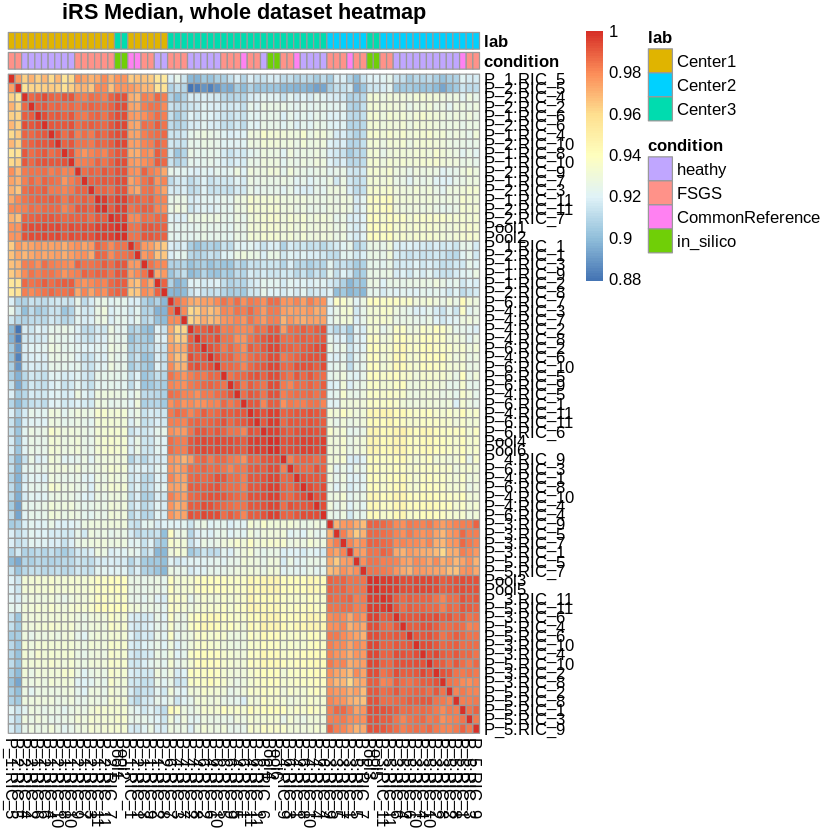

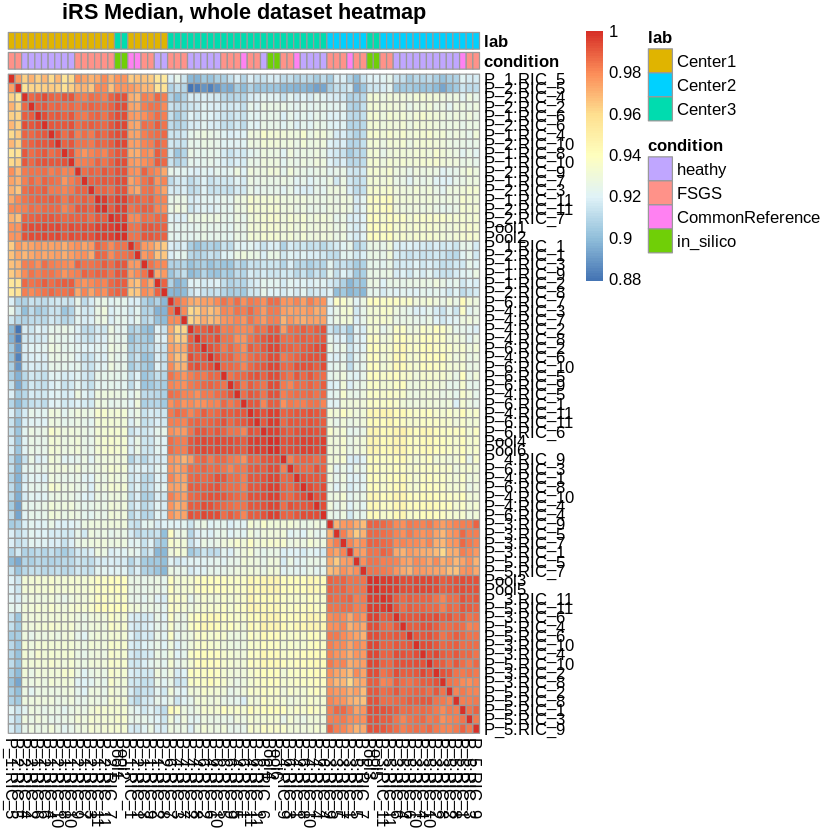

In [4]:
datasets_list = c('01_smaller_lib_balanced_PG_MajorPG')
labs_list = c('Center1', 'Center2', 'Center3')

for (dataset in datasets_list){
  path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/', dataset, "/")
  output_path = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/', dataset, '/results/')
  if(!dir.exists(output_path)){
    dir.create(output_path)
  }

  central_intensities = NULL
  central_counts = NULL

  central_batch_info = read_tsv(paste0(path_to_reports, 'metadata.tsv'), show_col_types = FALSE)
  central_batch_info <- central_batch_info  %>%
    mutate(Group = ifelse(Group == "Common Reference", "CommonReference", Group)) %>%
    mutate(
        file = Quantitative.column.name,
        lab = as.factor(Center),
        condition = factor(Group, levels = c('heathy', 'FSGS', "CommonReference"))
    )

  for (name in labs_list) {
    intensities = read_tsv(paste0(path_to_reports, name, '/pg_intensities.tsv'), show_col_types = FALSE)
    counts = read_tsv(paste0(path_to_reports, name, '/pg_counts.tsv'), show_col_types = FALSE)

    if(is.null(central_intensities)){
      central_intensities = intensities
      central_counts = counts
    } else {
      central_intensities = full_join(central_intensities, intensities, by = 'Majority.protein.IDs')
      central_counts = full_join(central_counts, counts, by = 'Majority.protein.IDs')
    }
  }

  cat('\n\nDataset: ', dataset, "\n")
  cat('\tNumber of proteins: ', nrow(central_intensities), '\n')
  cat('\tNumber of samples: ', ncol(central_intensities)-1, '\n')

  # transform and order
  central_intensities <- central_intensities %>% column_to_rownames('Majority.protein.IDs')
  central_counts <- central_counts %>% column_to_rownames('Majority.protein.IDs')

  central_intensities <- central_intensities[, central_batch_info$file]

  ########################################################################################
  # filter by condition
  intensities <- filter_na_proteins(central_intensities, central_batch_info, "file")
  central_intensities <- filter_by_condition(central_intensities, central_batch_info, 
        'file', c('heathy', 'FSGS'), 'condition')

  filter_list_META[[dataset]][['Central']] <- rownames(central_intensities)

  central_intensities <- filter_per_center(central_intensities, central_batch_info, "file",
    unique(central_batch_info$lab), 'lab')
  
  cat("Rows after all filters:", nrow(central_intensities), "\n")
  analyzed_proteins[[dataset]] <- rownames(central_intensities)
  

  ########################################################################################
  # NORMALIZATION
  # median normalization
  central_intensities <- medianNorm(central_intensities) %>% as.data.frame()

  corrected_intensities <- NULL
  updates_metadata <- NULL

  # irs with in silico reference
  for(center in labs_list){
    cat("IRS normalization for center: ", center, "\n")
    center_intensities <- central_intensities[, central_batch_info$lab == center]
    center_batch_info <- central_batch_info[central_batch_info$lab == center, ]

    irs_res <- irsNorm_in_silico_single_center(
      center_intensities, center_batch_info,
      pool_col = "Pool",
      column_name = "file",
      center = name,
      aggregation_method = "average"
    )

    # add to the central data
    if(is.null(corrected_intensities)){
      corrected_intensities = irs_res$corrected_data
      updates_metadata = irs_res$metadata
    } else {
      corrected_intensities = cbind(corrected_intensities, irs_res$corrected_data)
      updates_metadata = rbind(updates_metadata, irs_res$metadata)
    }
  }
  
  central_batch_info <- updates_metadata %>% as.data.frame() %>%
    mutate(
        file = as.character(file),
        lab = as.factor(as.character(lab)),
        Pool = as.factor(as.character(Pool)),
        condition = factor(as.character(condition), levels = c('heathy', 'FSGS', "CommonReference", "in_silico"))
      )

  central_intensities <- corrected_intensities %>% as.data.frame()
  central_intensities <- central_intensities[, central_batch_info$file]
  rownames(central_batch_info) <- central_batch_info$file

  # plot results
  create_plots(central_intensities, central_batch_info, "iRS Median, whole dataset",
    "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/01_smaller_lib_balanced_PG_MajorPG/IRS_median",
    shape_col = "lab", width = 20)
  
  ################################################################################################
  # DE analysis
  
  # select minimal count across column for each protein (with na.rm = TRUE)
  central_counts$count <- apply(central_counts, 1, min, na.rm = TRUE)
  central_counts <- central_counts %>% select(count)

  central_intensities <- log2(central_intensities + 1)

  # run DE analysis
  design <- make_design(central_batch_info, 'condition', 'Pool')
  contrasts <- makeContrasts(heathy-FSGS, levels = colnames(design))
  de_results <- run_DE(central_intensities, central_counts, design, contrasts)
  de_results <- de_results %>% rownames_to_column('Protein')
  write.table(de_results, file = paste0(output_path, "/central_res.tsv"), sep = "\t", quote = FALSE, row.names = FALSE)

  cat("Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25): ", sum((de_results$sca.adj.pval < 0.05 & abs(de_results$logFC) > 0.25)), "\n")

  # plot volcano plot
  plot_result <- volcano_plot(
    de_results, paste(dataset, "central", ", healthy/FSGS"),
    pval_threshold = 0.05, logfc_threshold = 0.25,
    show_names = FALSE
  )
  ggsave(file = paste0(output_path, '/central_volcano_plot.svg'), plot = plot_result, width = 8, height = 5)

  rownames(de_results) <- de_results$Protein
  plot_result <- volcano_plot(
    de_results, paste(dataset, "central", ", healthy/FSGS"),
    pval_threshold = 0.05, logfc_threshold = 0.25,
    show_names = TRUE
  )
  ggsave(file = paste0(output_path, '/central_volcano_plot_names.svg'), plot = plot_result, width = 8, height = 5)
}


# Separate run for meta

In [5]:
options(warn=-1)
datasets_list = c('01_smaller_lib_balanced_PG_MajorPG')
labs_list = c('Center1', 'Center2', 'Center3')


for(dataset in datasets_list){
  plots_list = list()
  plots_list_named = list()
  cat('\n\nDataset: ', dataset, "\n")
  
  for (name in labs_list) {
    path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/', dataset, '/', name, "/")
    output_path = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/', dataset, '/')
    
    if(!dir.exists(output_path)){
      dir.create(output_path, recursive = TRUE)
    }
    cat('\nLab: ', name, "\n")

    batch_info <- read.csv(paste0(path_to_reports, "metadata.tsv"), sep = "\t") %>%
      mutate(Group = ifelse(Group == "Common Reference", "CommonReference", Group)) %>%
      mutate(
          file = Quantitative.column.name,
          lab = as.factor(Center),
          condition = factor(Group, levels = c('heathy', 'FSGS', "CommonReference"))
      )
    rownames(batch_info) <- batch_info$file
    intensities <- read.csv(paste0(path_to_reports, "pg_intensities.tsv"), row.names=1, sep = "\t")
    intensities <- intensities[, batch_info$file]

    counts = read_tsv(paste0(path_to_reports, "/pg_counts.tsv"), show_col_types = FALSE)
    counts <- counts %>% column_to_rownames('Majority.protein.IDs') %>%
      rename(count = 'counts')
    
    filter_list_META[[dataset]][[name]] <- rownames(intensities)

    # filters (to analyze the same proteins)
    intensities <- intensities[analyzed_proteins[[dataset]],]
    cat("Rows after all filters:", nrow(intensities), "\n")

    # Normalization
    # median normalization
    intensities <- medianNorm(intensities) %>% as.data.frame()

    cat("IRS normalization for center: ", center, "\n")
    irs_results <- irsNorm_in_silico_single_center(intensities, batch_info, 
      pool_col = "Pool",
      column_name = "file",
      center = name,
      aggregation_method = "average"
    )
    intensities <- irs_res$corrected_data
    batch_info <- irs_res$metadata %>%
      mutate(condition = factor(condition, levels = c('heathy', 'FSGS', "CommonReference", "in_silico")),
            lab = as.factor(lab),
            Pool = as.factor(Pool))
    intensities <- intensities[, batch_info$file]
    rownames(batch_info) <- batch_info$file

    ################################################################################################
    # DE analysis
    intensities <- log2(intensities + 1)
    intensities <- intensities %>% as.data.frame()
    counts <- counts %>% as.data.frame()

    # run DE
    design <- make_design(batch_info, 'condition', "Pool")
    contrasts <- makeContrasts(heathy-FSGS, levels = colnames(design))
    de_results <- run_DE(intensities, counts, design, contrasts)
    de_results <- de_results %>% rownames_to_column('Protein')
    write.table(de_results, file = paste0(output_path, name, '_res_FULL.tsv'), sep = "\t", quote = FALSE, row.names = FALSE)

    cat("Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25): ", sum((de_results$sca.adj.pval < 0.05 & abs(de_results$logFC) > 0.25)), "\n")

    rownames(de_results) <- de_results$Protein
    # plot volcano plots
    if(name == 'Center3'){
      plot_separate <- volcano_plot(
        de_results, paste(dataset, name, ", heathy/FSGS"),
        pval_threshold = 0.05, logfc_threshold = 0.25,
        show_names = FALSE
      )
      plot_separate_N <- volcano_plot(
        de_results, paste(dataset, name, ", heathy/FSGS"),
        pval_threshold = 0.05, logfc_threshold = 0.25,
        show_names = TRUE
      )
    } else {
      plot_separate <- volcano_plot(
        de_results, paste(dataset, name, ", heathy/FSGS"),
        pval_threshold = 0.05, logfc_threshold = 0.25,
        show_names = FALSE, show_legend = FALSE
      )
      plot_separate_N <- volcano_plot(
        de_results, paste(dataset, name, ", heathy/FSGS"),
        pval_threshold = 0.05, logfc_threshold = 0.25,
        show_names = TRUE, show_legend = FALSE
      )
    }
    plots_list[[name]] = plot_separate
    plots_list_named[[name]] = plot_separate_N
  }

  layout <- (plots_list[['Center1']] | plots_list[['Center2']] | plots_list[['Center3']])
  ggsave(file = paste0(output_path, "volcano_plots.svg"), plot = layout, width = 25, height = 7)

  layout <- (plots_list_named[['Center1']] | plots_list_named[['Center2']] | plots_list_named[['Center3']])
  ggsave(file = paste0(output_path, "volcano_plots_names.svg"), plot = layout, width = 25, height = 7)

}


write_json(filter_list_META, "/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/filter_list_META.json")



Dataset:  01_smaller_lib_balanced_PG_MajorPG 

Lab:  Center1 
Rows after all filters: 355 
IRS normalization for center:  Center3 
Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  77 

Lab:  Center2 
Rows after all filters: 355 
IRS normalization for center:  Center3 
Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  77 

Lab:  Center3 
Rows after all filters: 355 
IRS normalization for center:  Center3 
Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  76 


In [9]:
design <- make_design(batch_info, 'condition', "Pool")

design

contrasts <- makeContrasts(heathy-FSGS, levels = colnames(design))
contrasts

,heathy,FSGS,CommonReference,in_silico,Pool6
1,0,0,1,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0
5,0,1,0,0,0
6,1,0,0,0,0
7,0,1,0,0,0
8,1,0,0,0,0
9,0,1,0,0,0
10,1,0,0,0,0


,heathy - FSGS
heathy,1
FSGS,-1
CommonReference,0
in_silico,0
Pool6,0


In [75]:
meta_filter <- list()


# prepare filter for meta-analyses
for(dataset in datasets_list){
  cat('\n\nDataset: ', dataset)
  for (name in labs_list) {
    if(is.null(meta_filter[[dataset]])){
      meta_filter[[dataset]] <- filter_list_META[[dataset]][[name]]
    } else {
      meta_filter[[dataset]] <- intersect(meta_filter[[dataset]], filter_list_META[[dataset]][[name]])
    }
  }
  cat("\n\tIntersection length:",  length(meta_filter[[dataset]]))
}



Dataset:  01_smaller_lib_balanced_PG_MajorPG
	Intersection length: 363

In [76]:
for(dataset in datasets_list){
  for (name in labs_list) {
    # reaed results
    de_results <- read_tsv(paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/', dataset, '/', name, '_res_FULL.tsv'), show_col_types = FALSE)
    de_results <- de_results %>% filter(Protein %in% meta_filter[[dataset]]) %>%
      arrange(desc(Protein))
    cat('\nDataset: ', dataset, 'Lab: ', name, 'Number of DE proteins: ', nrow(de_results))
    write.table(de_results, file = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/', dataset, '/', name, '_res.tsv'), sep = "\t", quote = FALSE, row.names = FALSE)
    }
}


Dataset:  01_smaller_lib_balanced_PG_MajorPG Lab:  Center1 Number of DE proteins:  355
Dataset:  01_smaller_lib_balanced_PG_MajorPG Lab:  Center2 Number of DE proteins:  355
Dataset:  01_smaller_lib_balanced_PG_MajorPG Lab:  Center3 Number of DE proteins:  355

run metaanalyses

In [77]:
# cd /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/

# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/ Center1 Center2 Center3
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaVolcanoR.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/ Center1 Center2 Center3
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_RankProd.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/ Center1 Center2 Center3

# cp /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/MA_* /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_balanced_PG_MajorPG/results/